## Human-in-Loop
For some actions, you may want to require human approval before running to ensure that everything is running as intended.

In Human-in-Loop, there will be human intervention before tool callinig asking for yes/no. based on the input from human, it will proceed further

In [32]:
import operator, json
from typing import TypedDict, Annotated, Sequence
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool

In [33]:
# Configuring gemini

from langchain_google_genai import ChatGoogleGenerativeAI

llm= ChatGoogleGenerativeAI(model= 'gemini-1.5-pro')


**LangGraph supports human-in-the-loop workflows in a number of ways. In this section, we will use LangGraph's interrupt_before functionality to always break the tool node.**

In [34]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

In [35]:
search= TavilySearchResults()

tools= [search]

llm_with_tools= llm.bind_tools(tools)

tool_node= ToolNode(tools)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [36]:
# Agent- llm_with_tools
def reasoner(state: AgentState):
    messages= state['messages']
    response= llm_with_tools.invoke(messages)
    return {'messages': [response]}
    

In [37]:
def router_function(state: AgentState):
    messages= state['messages']
    last_message= messages[-1]
    if last_message.tool_calls:
        return 'tools'
    else:
        return END

In [38]:
# Building the LangGraph- Human-in-loop

workflow= StateGraph(AgentState)

workflow.add_node('Agent', reasoner)
workflow.add_node('tools', tool_node)

workflow.add_edge(START, 'Agent')
workflow.add_conditional_edges('Agent', router_function, {'tools':'tools', END:END})
workflow.add_edge('tools', 'Agent')

memory= MemorySaver()
app= workflow.compile(checkpointer= memory, 
                      interrupt_before=['tools'] # Interrupt_before tools node
                    # Note: can also interrupt __after__ tools, if desired.
                    # interrupt_after=["tools"]
                      )


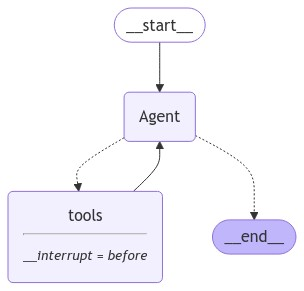

In [39]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [40]:
config= {'configurable':{'thread_id':'1'}}

input= 'what is capital of Tamil Nadu ?'

# The config is the **second positional argument** to stream() or invoke()!
events= app.stream({'messages':[input]}, config, stream_mode='values')

for event in events:
    if "messages" in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

what is capital of Tamil Nadu ?
{'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'type_': 6, 'description': 'Input for the Tavily tool.', 'properties': {'query': {'type_': 1, 'description': 'search query to look up', 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (1fc9e6ff-6aa7-4186-bc34-15274cfd42c9)
 Call ID: 1fc9e6ff-6aa7-4186-bc34-15274cfd42c9
  Args:
    query: what is capital of Tamil Nadu ?


In [ ]:
# code to check where human-in-loop is interrupted

snapshot = app.get_state(config)
snapshot.next

('tools',)

In [42]:
last_message=snapshot.values["messages"][-1]
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'what is capital of Tamil Nadu ?'},
  'id': '1fc9e6ff-6aa7-4186-bc34-15274cfd42c9',
  'type': 'tool_call'}]

In [43]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted

events= app.stream(None, config, stream_mode='values')

for event in events:
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (1fc9e6ff-6aa7-4186-bc34-15274cfd42c9)
 Call ID: 1fc9e6ff-6aa7-4186-bc34-15274cfd42c9
  Args:
    query: what is capital of Tamil Nadu ?
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://kids.britannica.com/students/article/Chennai/275604", "content": "The capital of Tamil Nadu state in southern India is Chennai, one of the country's largest cities. The city was formerly known as Madras. It is located on the Coromandel coast of the Bay of Bengal. Its climate is hot and humid. May, the hottest month, has a mean temperature of 90 °F (32 °C), but sea breezes moderate the summer heat."}, {"url": "https://en.wikipedia.beta.wmflabs.org/wiki/Chennai", "content": "Chennai (/ ˈ tʃ ɛ n aɪ / ⓘ, Template:IPA-ta), formerly known as Madras, [A] is the capital city of Tamil Nadu, the southernmost In

In [44]:
## To check the memory of LangGraph

input1= {'messages': ['what is the weather there ?']}

events1= app.stream(input1, config, stream_mode='values')

for event in events1:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

what is the weather there ?
{'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'type_': 6, 'description': 'Input for the Tavily tool.', 'properties': {'query': {'type_': 1, 'description': 'search query to look up', 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (e3a99ac8-0dda-4441-b9cc-5a3055d56434)
 Call ID: e3a99ac8-0dda-4441-b9cc-5a3055d56434
  Args:
    query: What is the weather in Chennai, India?


In [45]:
events1= app.stream(None, config, stream_mode='values')

for event in events1:
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (e3a99ac8-0dda-4441-b9cc-5a3055d56434)
 Call ID: e3a99ac8-0dda-4441-b9cc-5a3055d56434
  Args:
    query: What is the weather in Chennai, India?
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Chennai', 'region': 'Tamil Nadu', 'country': 'India', 'lat': 13.0833, 'lon': 80.2833, 'tz_id': 'Asia/Kolkata', 'localtime_epoch': 1733061563, 'localtime': '2024-12-01 19:29'}, 'current': {'last_updated_epoch': 1733060700, 'last_updated': '2024-12-01 19:15', 'temp_c': 26.2, 'temp_f': 79.2, 'is_day': 0, 'condition': {'text': 'Mist', 'icon': '//cdn.weatherapi.com/weather/64x64/night/143.png', 'code': 1030}, 'wind_mph': 17.2, 'wind_kph': 27.7, 'wind_degree': 109, 'wind_dir': 'ESE', 'pressure_mb': 1002.0, 'pressure_in': 29.59, 'precip_mm': 0.6

### Instead of getting the messages through tool, we can pass our own message

In [47]:
input2= {'messages': ['give me the recent news of it?']}

events2= app.stream(input2, config, stream_mode='values')

for event in events2:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

give me the recent news of it?
{'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'type_': 6, 'description': 'Input for the Tavily tool.', 'properties': {'query': {'type_': 1, 'description': 'search query to look up', 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (77b748f9-618d-4477-976b-c0d16233a7cc)
 Call ID: 77b748f9-618d-4477-976b-c0d16233a7cc
  Args:
    query: recent news Chennai India


In [48]:
# currently it's interrupted before Tools

snapshot=app.get_state(config) 
current_message = snapshot.values["messages"][-1]
current_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (77b748f9-618d-4477-976b-c0d16233a7cc)
 Call ID: 77b748f9-618d-4477-976b-c0d16233a7cc
  Args:
    query: recent news Chennai India


In [49]:
tool_call_id = current_message.tool_calls[0]["id"] 
tool_call_id

'77b748f9-618d-4477-976b-c0d16233a7cc'

In [50]:
from langchain_core.messages import AIMessage, ToolMessage

answer = "it is just related to expecting heavy rainfall for next 2 days due to cyclone Fengal which is formed in bay of bengal"


new_messages = [
    ToolMessage(content=answer, tool_call_id=tool_call_id),
    AIMessage(content=answer),
]


In [51]:
app.update_state(
    config,
    {"messages": new_messages},)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efafedb-3211-6ead-800c-770c06484f06'}}

In [52]:
print(app.get_state(config).values["messages"][-1:])

[AIMessage(content='it is just related to expecting heavy rainfall for next 2 days due to cyclone Fengal which is formed in bay of bengal', additional_kwargs={}, response_metadata={}, id='e42c71ff-3dfa-472b-a96a-3378136a0107')]
